In [7]:
# setup umbrella sampling WC and HG states

import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pyemma as py
import scipy
import sys, os

import math
import glob 

import MDAnalysis as mda
import nglview as ng
from nglview import NGLWidget
import mdtraj as md

import matplotlib.colors as mcolors
import matplotlib.cm as cm

#from wham import wham

/project/andrewferguson/Mike/conda_envs/abasic_env/lib/python3.8/site-packages/MDAnalysis/coordinates/chemfiles.py:59: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")


In [8]:
def load_colvar(cv_path):

    lines = open(cv_path, 'r').readlines()
    labels = lines[0].split()[2:]

    all_data = []
    for line in lines:
        try:
            data = np.array([float(x) for x in line.split()])
            all_data.append(data)
        except:
            pass

    return np.array(all_data), labels

metad_path = '/project/andrewferguson/Smayan/aa_oligos/jobs_MJ/restarts/metad/jobs/'
rew_file = '/project/andrewferguson/Smayan/aa_oligos/jobs_MJ/restarts/metad/opes-metad/FES_from_Reweighting.py'
cur_path = '/project/andrewferguson/Mike/cut_analysis/umbrella_sampling/'
fes_path = '/project/andrewferguson/Smayan/aa_oligos/jobs_MJ/restarts/metad/jobs/'

['/project/andrewferguson/Smayan/aa_oligos/jobs_MJ/restarts/metad/jobs//walkers-long-pace-500_cmap_diff_beta20_b-20/W_1', '/project/andrewferguson/Smayan/aa_oligos/jobs_MJ/restarts/metad/jobs//walkers-long-pace-500_cmap_diff_beta20_b-20/W_2', '/project/andrewferguson/Smayan/aa_oligos/jobs_MJ/restarts/metad/jobs//walkers-long-pace-500_cmap_diff_beta20_b-20/W_3', '/project/andrewferguson/Smayan/aa_oligos/jobs_MJ/restarts/metad/jobs//walkers-long-pace-500_cmap_diff_beta20_b-20/W_4']


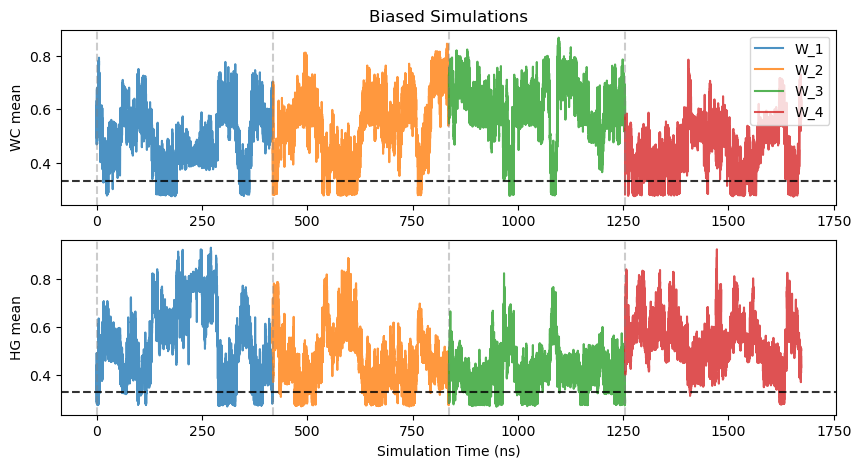

In [9]:
# figures showing WC-HG transitions in equilibrium and biased data

job_list = glob.glob(f'{metad_path}/walkers-long-pace-500_cmap_diff_beta20_b-20/W*')
print(job_list)

stride = 10
ts = 0.001   # biased timesteps are saved once every ps

fig, axes = plt.subplots(2, figsize=(10, 5))

for cv_name, ax in zip(['WC.mean', 'HG.mean'], axes):

    for i, job in enumerate(job_list):
        colvar_name = job + '/COLVAR*'
        colvar_name = glob.glob(colvar_name)[0]
        job_label = job.split('/')[-1]

        cvs, labels = load_colvar(colvar_name)
        for cv, label in zip(cvs.T, labels):
            if label == cv_name:

                n = len(cv[::stride])
                x = ts * np.arange(i*n, (i+1)*n) * stride

                ax.plot(x, cv[::stride], label=job_label, alpha=0.8) 
                ax.axvline(ts *i*n*stride, alpha=0.4, linestyle='dashed', c='gray')
                
                np.save(f'./npy_hg_wc_221201/walkers_{cv_name}_{i}', cv)
                 
    ax.axhline(0.33, alpha=0.8, linestyle='dashed', c='black')
    ax.set_ylabel(cv_name.replace('.', ' '))
    

ax.set_xlabel('Simulation Time (ns)')
axes[0].legend()
axes[0].set_title('Biased Simulations')

# save as svg
plt.savefig('../svgs_221122/wc_hg_traj_biased.svg')

#axes.set_title(job_list[-1].split('/')[-2])

(2001,)
(2001,)
(2001,)
(2001,)


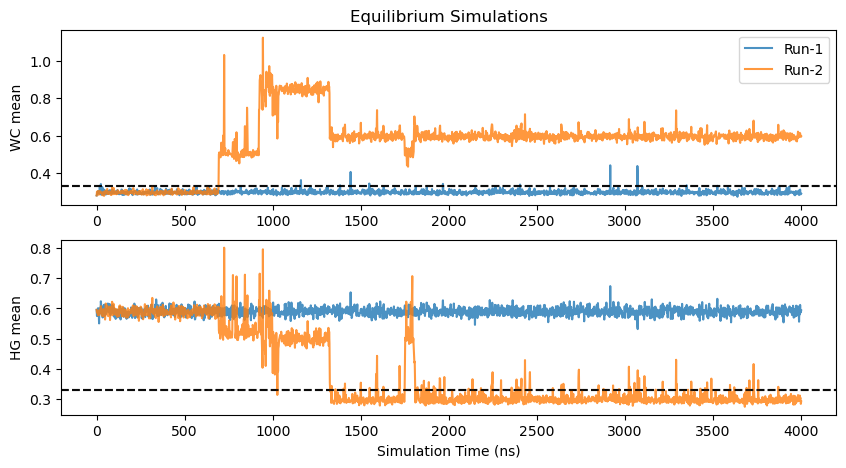

In [10]:
# now do the same thing for equlibrium simulation

stride = 10
ts = 0.2 # biased trajs saved once every 200 ps

fig, axes = plt.subplots(2, figsize=(10, 5))

# copied from plumed bias
wc_pairs = [(208,683), (211,684), (240,651), (243,652)]
hg_pairs = [(205,684), (208,687), (237,652), (240,655)]

# adjust for 0-indexing
wc_pairs = np.array(wc_pairs) - 1
hg_pairs = np.array(hg_pairs) - 1

traj_paths = sorted(glob.glob('../Biobb_analysis/md/2000ns_310K_cut_BSC1_DNA*/'))
labels = ['Run-1', 'Run-2']

for traj_path, label in zip(traj_paths, labels):

    xtc = f'{traj_path}md_nosolv.xtc'
    pdb = f'{traj_path}md_nosolv.pdb'

    traj = md.load(xtc, top=pdb)[::stride]
    wc_mean = md.compute_distances(traj, wc_pairs).mean(axis=1)
    hg_mean = md.compute_distances(traj, hg_pairs).mean(axis=1)

    x = ts * np.arange(len(wc_mean)) * stride

    axes[0].plot(x, wc_mean, label=label, alpha=0.8) 
    axes[0].axhline(0.33, alpha=0.8, linestyle='dashed', c='black')

    axes[1].plot(x, hg_mean, label=label, alpha=0.8) 
    axes[1].axhline(0.33, alpha=0.8, linestyle='dashed', c='black')

    print(wc_mean.shape)
    print(hg_mean.shape)
    
    np.save(f'./npy_hg_wc_221201/equ_WC.mean_{label}', wc_mean)
    np.save(f'./npy_hg_wc_221201/equ_HG.mean_{label}', hg_mean)

axes[0].legend()
axes[1].set_xlabel('Simulation Time (ns)')
axes[0].set_ylabel('WC mean')
axes[1].set_ylabel('HG mean')
axes[0].set_title('Equilibrium Simulations')

plt.savefig('../svgs_221122/wc_hg_traj_equ.svg')

In [11]:
# reweight using WC and HG as cutoffs

# load reweighted FES and plot

def load_FES(job_list, fes_name, label=None, show_error=False, plot=True):
    
    fes_list = []
    for job in job_list:
        
        fes = f'{job}/{fes_name}'
        lines = open(fes, 'r').readlines()
        labels = lines[0].split()[2:]

        all_data = []
        for line in lines:
            try:
                data = np.array([float(x) for x in line.split()])
                all_data.append(data)
            except:
                pass
            
        all_data = np.array(all_data)
        fes_list.append(all_data)

    return fes_list

    
def plot_prob(dat_list, labels, axes, cv_max=0.35, kT=2.58):
    
    state_prob_list = []
    for dat, label in zip(dat_list, labels):
        
        cv = dat[:, 0]
        fe = dat[:, 1]
        er = dat[:, 2]
        
        prob_min = np.exp(-(fe-er)/kT)
        prob_mean = np.exp(-fe/kT)
        prob_max = np.exp(-(fe+er)/kT)
        
        # calculate probabilty of state indices
        state_idxs = np.where(cv < cv_max)
        
        state_prob_min = np.sum(prob_min[state_idxs]) / np.sum(prob_min)
        state_prob_mean = np.sum(prob_mean[state_idxs]) / np.sum(prob_mean)
        state_prob_max = np.sum(prob_min[state_idxs]) / np.sum(prob_max)
        
        state_prob_list.append(np.array([state_prob_min, state_prob_mean, state_prob_max]))
        
        # plot average value
        line = axes.plot(cv, prob_mean, label=label)
        c = line[0].get_color()
        
        # plot values derived from error
        axes.plot(cv, prob_min, label=label, c=c, linestyle='dashed')
        axes.plot(cv, prob_max, label=label, c=c, linestyle='dashed')
        
    return np.array(state_prob_list)


def load_single_FES(job, fes_name, label=None, show_error=False, plot=True):
    
        
    fes = f'{job}/{fes_name}'
    lines = open(fes, 'r').readlines()
    labels = lines[0].split()[2:]

    all_data = []
    for line in lines:
        try:
            data = np.array([float(x) for x in line.split()])
            all_data.append(data)
        except:
            pass

    all_data = np.array(all_data)

    return all_data
    

def plot_single_prob(dat, label, axes, cv_max=0.35, kT=2.58):
        
    cv = dat[:, 0]
    fe = dat[:, 1]
    er = dat[:, 2]

    prob_min = np.exp(-(fe-er)/kT)
    prob_mean = np.exp(-fe/kT)
    prob_max = np.exp(-(fe+er)/kT)

    # calculate probabilty of state indices
    state_idxs = np.where(cv < cv_max)

    state_prob_min = np.sum(prob_min[state_idxs]) / np.sum(prob_min)
    state_prob_mean = np.sum(prob_mean[state_idxs]) / np.sum(prob_mean)
    state_prob_max = np.sum(prob_min[state_idxs]) / np.sum(prob_max)

    # plot average value
    line = axes.plot(cv, prob_mean, label=label)
    c = line[0].get_color()

    # plot values derived from error
    axes.plot(cv, prob_min, label=label, c=c, linestyle='dashed')
    axes.plot(cv, prob_max, label=label, c=c, linestyle='dashed')
        
    return np.array([state_prob_min, state_prob_mean, state_prob_max])


def get_fes_diff(WC_prob, HG_prob, kT):

    wc_diff = WC_prob / (WC_prob + HG_prob)
    hg_diff = HG_prob / (WC_prob + HG_prob)
    fes_diff = -np.log(wc_diff)*kT + np.log(hg_diff)*kT
    
    return fes_diff

/project/andrewferguson/Smayan/aa_oligos/jobs_MJ/restarts/metad/jobs/walkers-long-pace-500_cmap_diff_beta20_b-10 dna_b-10

 using cv "WC.mean" found at column 8
 using bias "a_up.bias" found at column 20
 using bias "a_dn.bias" found at column 22
 using bias "b7_up.bias" found at column 24
 using bias "b8_up.bias" found at column 26
 using bias "b67_up.bias" found at column 28
 using bias "b89_up.bias" found at column 30
 using bias "AA_up.bias" found at column 32
 using bias "opes.bias" found at column 34
 printing 10 FES files, one every 174108 samples
 first 4 samples discarded to fit with given stride
+++ IMPORTANT: remember to try different numbers of blocks and check for the convergence of the uncertainty estimate +++
 printing final FES with block average to fes-rew.dat
 number of blocks is 10, while effective number is 8.99287
 average FES uncertainty is: 0.9859837545991315
                              

 using cv "HG.mean" found at column 9
 using bias "a_up.bias" found at co

 printing 10 FES files, one every 38428 samples
 first 4 samples discarded to fit with given stride
+++ IMPORTANT: remember to try different numbers of blocks and check for the convergence of the uncertainty estimate +++
 printing final FES with block average to fes-rew.dat
 number of blocks is 10, while effective number is 9.29194
 average FES uncertainty is: 0.9319190246436845
                              
-8.002836678021353 -7.459575374549184 -5.6527538464319935
/project/andrewferguson/Smayan/aa_oligos/jobs_MJ/restarts/metad/jobs/walkers-des-long-pace-500_cmap_diff_beta20_b-15 des-dna_b-15

 using cv "WC.mean" found at column 8
 using bias "a_up.bias" found at column 20
 using bias "a_dn.bias" found at column 22
 using bias "b7_up.bias" found at column 24
 using bias "b8_up.bias" found at column 26
 using bias "b67_up.bias" found at column 28
 using bias "b89_up.bias" found at column 30
 using bias "AA_up.bias" found at column 32
 using bias "opes.bias" found at column 34
 printing

+++ IMPORTANT: remember to try different numbers of blocks and check for the convergence of the uncertainty estimate +++
 printing final FES with block average to fes-rew.dat
 number of blocks is 10, while effective number is 9.73377
 average FES uncertainty is: 0.747211091199399
                              

 using cv "HG.mean" found at column 9
 using bias "a_up.bias" found at column 19
 using bias "a_dn.bias" found at column 21
 using bias "b7_up.bias" found at column 23
 using bias "b8_up.bias" found at column 25
 using bias "b67_up.bias" found at column 27
 using bias "b89_up.bias" found at column 29
 using bias "AA_up.bias" found at column 31
 using bias "opes.bias" found at column 33
 printing 10 FES files, one every 159900 samples
 first 4 samples discarded to fit with given stride
+++ IMPORTANT: remember to try different numbers of blocks and check for the convergence of the uncertainty estimate +++
 printing final FES with block average to fes-rew.dat
 number of blocks is 1

1.35776566067185 4.36931853961691 6.942763177206705
/project/andrewferguson/Smayan/aa_oligos/jobs_MJ/restarts/metad/jobs/walkers-rna-des_cmap_diff_beta20_b-20 rna-des_b-20

 using cv "WC.mean" found at column 8
 using bias "a_up.bias" found at column 19
 using bias "a_dn.bias" found at column 21
 using bias "b7_up.bias" found at column 23
 using bias "b8_up.bias" found at column 25
 using bias "b67_up.bias" found at column 27
 using bias "b89_up.bias" found at column 29
 using bias "AA_up.bias" found at column 31
 using bias "opes.bias" found at column 33
 printing 10 FES files, one every 132932 samples
 first 4 samples discarded to fit with given stride
+++ IMPORTANT: remember to try different numbers of blocks and check for the convergence of the uncertainty estimate +++
 printing final FES with block average to fes-rew.dat
 number of blocks is 10, while effective number is 9.8896
 average FES uncertainty is: 0.5328770772295275
                              

 using cv "HG.mean" foun

FileNotFoundError: [Errno 2] No such file or directory: './save_fes_diff_230215/bias_factor_list.npy'

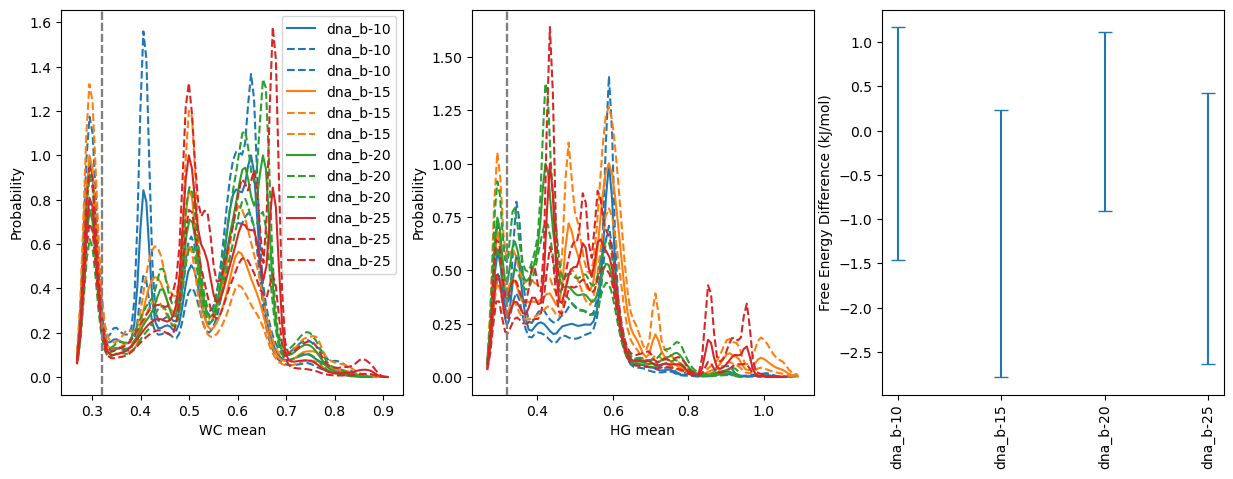

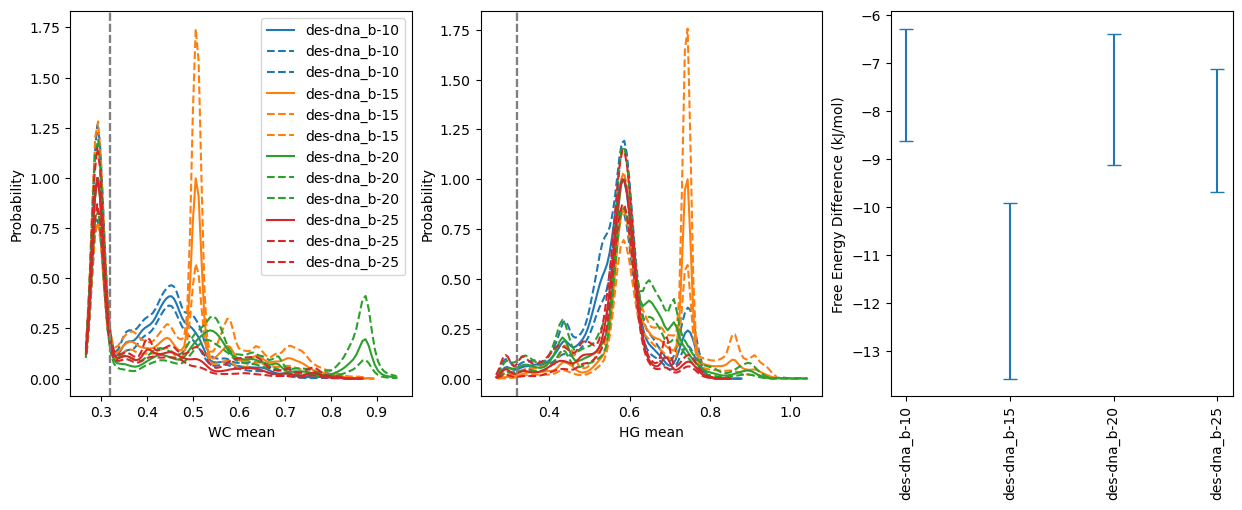

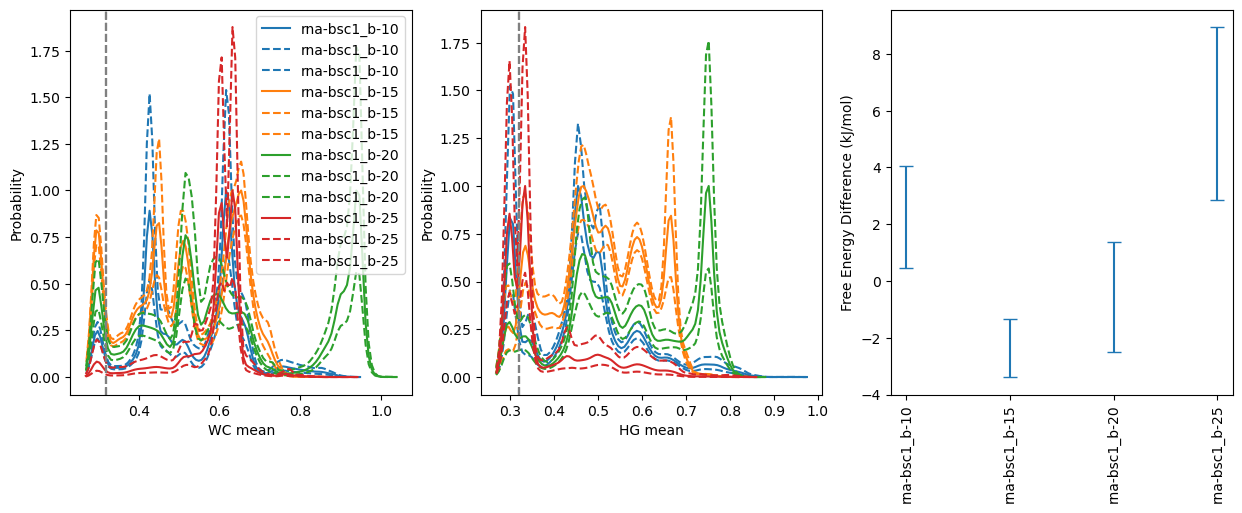

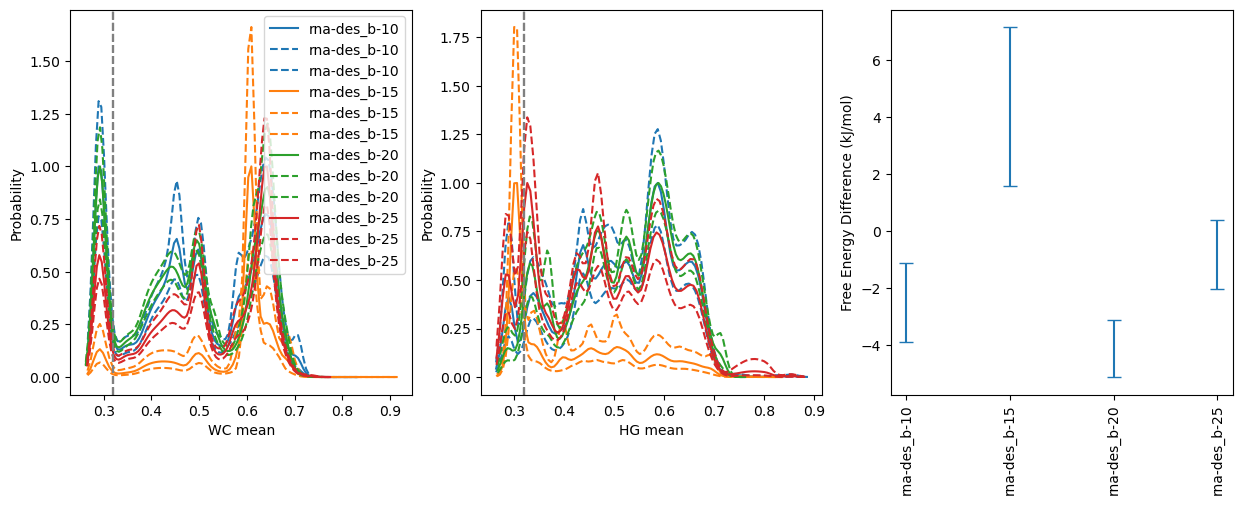

In [15]:
# reweight a list of files to the same cv and plot


dna_bsc_list = sorted(glob.glob(f'{metad_path}/walkers-long-pace-500*'))
dna_des_list = sorted(glob.glob(f'{metad_path}/walkers-des-long-pace-500*'))
rna_bsc_list = sorted(glob.glob(f'{metad_path}/walkers-rna-bsc1_cmap*'))
rna_des_list = sorted(glob.glob(f'{metad_path}/walkers-rna-des_cmap*'))  # rerun also an option

sim_type_list = [dna_bsc_list, dna_des_list, rna_bsc_list, rna_des_list]

blocks = 10
skip = 1000 #100000  #    # make sure to sort calcauars
kT = 2.58
show_error = True

#WC_max, HG_max = 0.32, 0.32
cv_max = 0.32

c_list = ['red', 'blue', 'orange', 'green']
all_fes_diff = []
all_fes_err = []
all_labels = []

for job_list, c in zip(sim_type_list, c_list):

    label_list = [job.split('/')[-1].replace('walkers-', '').replace('cmap_diff_beta20_', '').replace('long-pace-500', 'dna') for job in job_list]

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    fes_diff_list = []
    fes_err_list = []
    
    for job, label in zip(job_list, label_list):
        
        print(job, label)

        # switch into job dir
        fes_job = f'{job}/'
        os.chdir(fes_job)

        # run reweight and convert to prob for WC mean
        ! ../../opes-metad/FES_from_Reweighting.py --skiprows {skip} --cv WC.mean --kt {kT} --sigma 0.01 --blocks {blocks}
        fes = load_single_FES(job, 'fes-rew.dat')
        WC_prob = plot_single_prob(fes, label=label, cv_max=cv_max, axes=axes[0], kT=kT)
 
        # run reweight and convert to prob for HG mean
        ! ../../opes-metad/FES_from_Reweighting.py --skiprows {skip} --cv HG.mean --kt {kT} --sigma 0.01 --blocks {blocks}
        fes = load_single_FES(job, 'fes-rew.dat')
        HG_prob = plot_single_prob(fes, label=label, cv_max=cv_max, axes=axes[1], kT=kT)

        # change back to main dir
        os.chdir(cur_path)
        
        # just use means for now
        fes_diff = get_fes_diff(WC_prob[1], HG_prob[1], kT)
        fes_diff_list.append(fes_diff)
        
        # compute error from the difference of min/max
        fes_max = get_fes_diff(WC_prob[0], HG_prob[-1], kT)
        fes_min = get_fes_diff(WC_prob[-1], HG_prob[0], kT)
        fes_err = (fes_max - fes_min) / 2 
        fes_err_list.append(fes_err)
        
        print(fes_min, fes_diff, fes_max)

        for ax, xlab in zip(axes, ['WC mean', 'HG mean']):
            ax.axvline(cv_max, c='gray', linestyle='dashed')
            ax.set_xlabel(xlab)
            ax.set_ylabel('Probability')
        
    axes[0].legend()

    axes[2].errorbar(np.arange(len(fes_diff_list)), fes_diff_list, yerr=fes_err_list, capsize=5, linestyle='')
    axes[2].set_xticks(np.arange(len(fes_diff_list)))
    axes[2].set_xticklabels(label_list, rotation=90)
    axes[2].set_ylabel('Free Energy Difference (kJ/mol)')
    
    all_fes_diff += fes_diff_list
    all_fes_err += fes_err_list
    all_labels += label_list
    

In [17]:
# save mean and errors for each biasfactor
bf_list = [10, 15, 20, 25]
np.save(f'./save_fes_diff_230215/bias_factor_list.npy', bf_list)

for i, bf in enumerate(bf_list):
    np.save(f'./save_fes_diff_230215/mean_bf-{bf}.npy', all_fes_diff[i::4])
    np.save(f'./save_fes_diff_230215/error_bf-{bf}.npy', all_fes_err[i::4])

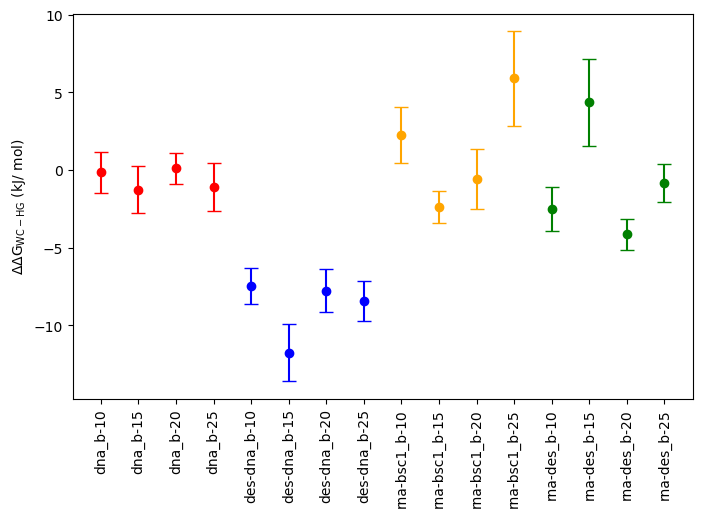

In [18]:
# plot all results together

fig, ax_main = plt.subplots(figsize=(8,5))
    
color_list = ['red', 'blue', 'orange', 'green']
    
for i, c in enumerate(color_list):
    i_range = np.arange(i*4, (i+1)*4)
    ax_main.errorbar(i_range, np.array(all_fes_diff)[i_range], yerr=np.array(all_fes_err)[i_range], 
                     marker='o',  capsize=5, linestyle='', ecolor=c, color=c)

ax_main.set_xticks(np.arange(len(all_labels)))
ax_main.set_xticklabels(all_labels, rotation=90)
ax_main.set_ylabel(r'$\Delta \Delta G_{WC - HG} $ (kJ/ mol)')

np.save('./npy_hg_wc_221201/metad_dG_from_prob', all_fes_diff)

### Load pressure for dinucleotides

/project/andrewferguson/Smayan/aa_oligos/jobs_MJ/restarts/metad/jobs/walkers-long-pace-500_cmap_diff_beta20_b-10/W_1/md.log
/project/andrewferguson/Smayan/aa_oligos/jobs_MJ/restarts/metad/jobs/walkers-long-pace-500_cmap_diff_beta20_b-10/W_1/COLVAR.0
(2178, 38) ['time', 'cmap_WC', 'cmap_HG', 'cmap_diff', 'cmap_WC_beta20', 'cmap_HG_beta20', 'cmap_diff_beta20', 'WC.mean', 'HG.mean', 'diff', 'd_com', 'd_b7', 'd_b8', 'd_b67', 'd_b89', 's_dist', 'eRMSD_AA', 'a_back', 'a_phos', 'a_up.bias', 'a_up.force2', 'a_dn.bias', 'a_dn.force2', 'b7_up.bias', 'b7_up.force2', 'b8_up.bias', 'b8_up.force2', 'b67_up.bias', 'b67_up.force2', 'b89_up.bias', 'b89_up.force2', 'AA_up.bias', 'AA_up.force2', 'opes.bias', 'opes.rct', 'opes.zed', 'opes.neff', 'opes.nker']
29502
/project/andrewferguson/Smayan/aa_oligos/jobs_MJ/restarts/metad/jobs/walkers-long-pace-500_cmap_diff_beta20_b-10/W_2/md.log
/project/andrewferguson/Smayan/aa_oligos/jobs_MJ/restarts/metad/jobs/walkers-long-pace-500_cmap_diff_beta20_b-10/W_2/COLV

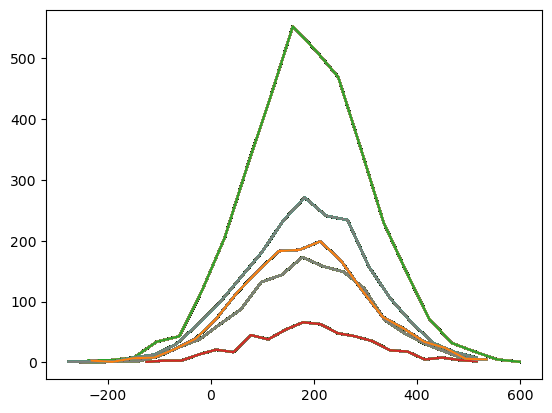

In [70]:
# can we use pressure information to convert to Gibbs?
# find average pressure for each fes bin?
# what resolution pressure data do we have?

# gather data for all wlaker

step_list, pres_list, cv_list = [], [], []

job_path = '/project/andrewferguson/Smayan/aa_oligos/jobs_MJ/restarts/metad/jobs/walkers-long-pace-500_cmap_diff_beta20_b-10/'

log_files = sorted(glob.glob(f'{job_path}/*/md.log'))
cv_files = sorted(glob.glob(f'{job_path}/*/*COLVAR*'))

for log_file, cv_file in zip(log_files, cv_files):
    print(log_file)
    print(cv_file)

    # load CV and stride to match pressure output
    cv, labels = load_colvar(cv_file)
    cv = cv[::200]
    print(cv.shape, labels)
    
    # append to cv as a list
    cv_list += [x for x in cv]

    log_txt = open(log_file, 'r').readlines()
    print(len(log_txt))

    for i, line in enumerate(log_txt):

        # append step value in next line
        if 'Step           Time' in line:
            step_list.append(float(log_txt[i+1].split()[0]))

        # append pres value in next line
        if 'Pressure (bar)' in line:
            pres_list.append(float(log_txt[i+1].split()[1]))
             
        
step_list, pres_list, cv_list = np.array(step_list), np.array(pres_list), np.array(cv_list)

        

[0.275877   0.31718158 0.35848616 0.39979074 0.44109532 0.48239989
 0.52370447 0.56500905 0.60631363 0.64761821 0.68892279 0.73022737
 0.77153195 0.81283653 0.85414111 0.89544568 0.93675026 0.97805484
 1.01935942 1.060664  ]
8712
[1 3 3 4 5 3 6 5 4 6]
8712 8712


/project/andrewferguson/Mike/conda_envs/abasic_env/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/project/andrewferguson/Mike/conda_envs/abasic_env/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/project/andrewferguson/Mike/conda_envs/abasic_env/lib/python3.8/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/project/andrewferguson/Mike/conda_envs/abasic_env/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/project/andrewferguson/Mike/conda_envs/abasic_env/lib/python3.8/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encount

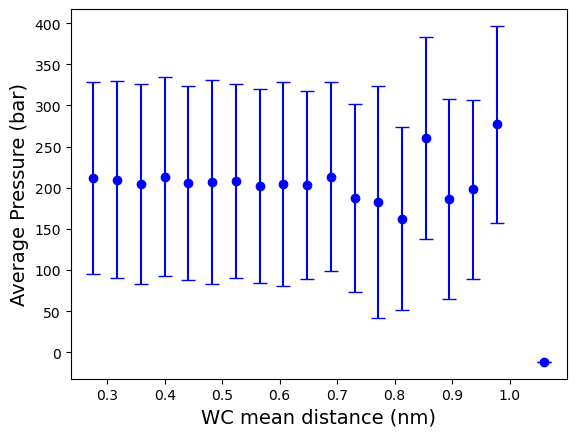

In [85]:
# histogram cv into 5 bins for 5 coarse WC states

cv_wc = cv_list[:, 8]
bins = np.linspace(min(cv_wc), max(cv_wc), 20)

print(bins)

hist_idxs = np.digitize(cv_wc, bins=bins, right=False)

# get pressure distribution for each each hist
for idx, b in zip(np.arange(min(hist_idxs), max(hist_idxs)+1), bins):
    
    d_idxs = np.where(hist_idxs==idx)[0]
    
    #h, b = np.histogram(pres_list[d_idxs], bins=20)
    
    p_mean, p_std = np.mean(pres_list[d_idxs]), np.std(pres_list[d_idxs])
    #p_mean, p_std = np.mean(cv_wc[d_idxs]), np.std(cv_wc[d_idxs])
    
    plt.errorbar(b, p_mean, yerr=p_std, capsize=5, marker='o', c='b')
    plt.xlabel('WC mean distance (nm)', fontsize=14)
    plt.ylabel('Average Pressure (bar)', fontsize=14)

print(len(hist_idxs))

print(hist_idxs[:10])
        
print(len(step_list), len(pres_list))

#plt.scatter(cv_wc, hist_idxs)

In [55]:
435521/2178 

199.9637281910009

In [11]:
print(state_prob_list[0])
print(state_prob_list[1])

print(fes_diff)

[0.18145018 0.1824191  0.32272177]
[0.12258091 0.11222819 0.22319839]
[-1.01190139 -1.2532932  -0.95132223]


### Create xtc and pdb with no solvent

echo 'DNA' | gmx trjconv -f md.xtc -s md.tpr -o md_nosolvent.xtc -pbc nojump

echo 'DNA' | gmx trjconv -f md.xtc -s md.tpr -o md_nosolvent.pdb -skip 10000

In [ ]:
# visualize multiple configurations 

# load and visualize traj without converting to solvent free

#xtc = f'{mj_path}/HG/save_all_cpts/md_new.xtc'
#xtc = f'{mj_path}/HG/test_ermsd/md_new.xtc'

metad_path = '/project/andrewferguson/Smayan/aa_oligos/jobs_MJ/restarts/metad/jobs/'
job_name = 'walkers_cmap_diff_beta20_b-20/W_1/' #'walkers-rna-bsc1_cmap_diff_beta20_b-10/W_1/'

xtc = f'{metad_path}{job_name}md_nosolvent.xtc'  #md.xtc
pdb = f'{metad_path}{job_name}md_nosolvent.pdb'  #md_RNA-des_withsolvent.pdb'

all_indices = np.arange(880)

# load and center DNA only
traj = md.load(xtc, top=pdb, atom_indices=all_indices)  # for DNA
#traj = md.load(xtc, top=pdb, atom_indices=np.arange(902))  # for RNA

center_res = [np.arange(6), np.arange(6, 8), np.arange(8, 14), np.arange(14, 28)] 
traj = traj.image_molecules([[set([a for a in traj.topology.residue(i).atoms]) for i in j] for j in center_res])

traj = traj.superpose(traj, frame=0)

# extrct AA slice
AA = traj.atom_slice(np.arange(190, 253))   # for DNA
#AA = traj.atom_slice(np.arange(196, 261))   # for RNA

# load traj
view = NGLWidget() #ng.show_mdtraj(dinuc_cut)
view.add_trajectory(traj[:])
view.add_trajectory(AA[:])

#view.add_representation('cartoon')
c_list = ['blue', 'red']
op_list = [0.4, 1.0]

for v, c, op in zip(view, c_list, op_list):
    v.clear_representations()
    v.add_representation('licorice', selection='not hydrogen', color=c, opacity=op)
view

In [ ]:
# load top only

#WC_pdb = '/project/andrewferguson/Smayan/aa_oligos/jobs_MJ/restarts/metad/des_jobs/md_WC.pdb'
#HG_pdb = '/project/andrewferguson/Smayan/aa_oligos/jobs_MJ/restarts/metad/des_jobs/md_HG.pdb'
#WC =  md.load(WC_pdb)
#HG =  md.load(HG_pdb)
#center_res = [np.arange(6), np.arange(6, 8), np.arange(8, 14), np.arange(14, 28)] 
#HG = HG.image_molecules([[set([a for a in HG.topology.residue(i).atoms]) for i in j] for j in center_res])

# load from different timestep
WC_time = 80
HG_time = 31
WC =  traj[WC_time]
HG =  traj[HG_time]

# indexes of regions of interest
#scaffold_idxs = np.concatenate([ np.arange(157, 191) ,  np.arange(254, 285), np.arange(599, 723) ])
#scaffold_idxs = np.concatenate([ np.arange(127, 191) ,  np.arange(254, 318), np.arange(569, 756) ])
scaffold_idxs = np.arange(632, 692)
AA_idxs = np.arange(191, 254)

# superpose based on scaffold regions
HG = HG.superpose(WC, atom_indices=scaffold_idxs)

# assign segments
scaffold = WC.atom_slice(scaffold_idxs)
AA_WC = WC.atom_slice(AA_idxs)
AA_HG = HG.atom_slice(AA_idxs)

# load traj
view = NGLWidget() #ng.show_mdtraj(dinuc_cut)
view.add_trajectory(scaffold)
view.add_trajectory(AA_WC)
view.add_trajectory(AA_HG)

#view.add_representation('cartoon')
c_list = ['black', 'blue', 'red']
op_list = [0.15, 0.8, 0.8]

for v, c, op in zip(view, c_list, op_list):
    v.clear_representations()
    v.add_representation('licorice', selection='not hydrogen', color=c, opacity=op)
view